In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import odl
import pykeops
import imageio
from torch.autograd import grad
from torch.nn.functional import grid_sample

import math
from pykeops.torch import LazyTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


torch.Size([64, 64, 2])


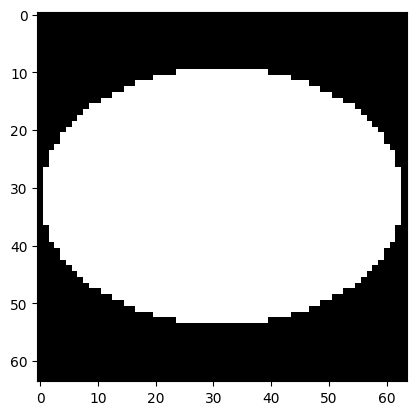

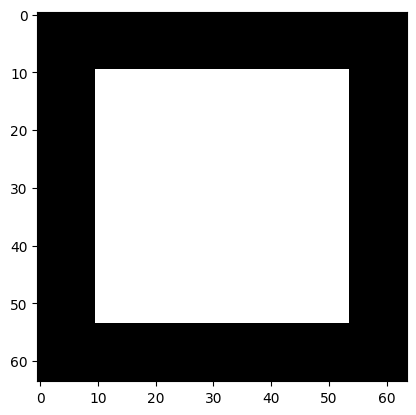

In [3]:
H, W = 64, 64
x = torch.linspace(-1, 1, H)
y = torch.linspace(-1, 1, W)
X, Y = torch.meshgrid(x, y, indexing='ij')  
grid = torch.stack((X, Y), dim=-1)

print(grid.shape)


I0 = torch.where(grid[:, :, 0]**2/0.5 + grid[:, :, 1]**2/0.99 <=1, 1.0, 0.0)

plt.imshow(I0.cpu(), cmap='gray')
plt.show()
I1 = torch.where((torch.abs(grid[...,0]) <= 0.7) & (torch.abs(grid[...,1]) <= 0.7), 1.0, 0.0)

plt.imshow(I1.cpu(), cmap='gray')
plt.show()


In [4]:
def warp_image_torch(img, disp):
    """
    img: 1 x 1 H x W
    disp: H x W x 2
    """
    N, C, H, W = img.shape
    if disp.shape[0] == 2 and disp.shape[1] == H and disp.shape[2] == W:
        dy = disp[0]
        dx = disp[1]
    elif disp.shape == (H, W, 2):
        dx = disp[..., 0]
        dy = disp[..., 1]
    else:
        raise ValueError("disp format not recognized")
    
    grid_y, grid_x = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=img.device),
        torch.arange(W, dtype=torch.float32, device=img.device),
        indexing='ij'
    )

    coords_x = grid_x + dx
    coords_y = grid_y + dy

    coords_x = 2.0 * coords_x / (W - 1) - 1.0
    coords_y = 2.0 * coords_y / (H - 1) - 1.0

    coords = torch.stack((coords_x, coords_y), dim=-1)
    coords = coords.unsqueeze(0)

    warped = grid_sample(img, coords, mode='bilinear', align_corners=True)[0, 0]
    return warped # H x W


def integrate_flow(v_func, n_steps, shape):
    """v_t: n_steps x H x W x 2"""
    H, W = shape
    ys = torch.linspace(-1, 1, H)
    xs = torch.linspace(-1, 1, W)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    phi = torch.stack((Y, X), dim=-1)
    dt = 1.0 / n_steps
    for i in range(n_steps):
        v_ti = v_func[i] 
        v_phi = torch.nn.functional.grid_sample(
            v_ti.permute(2, 0, 1).unsqueeze(0),
            phi.unsqueeze(0), align_corners=True
        )[0].permute(1, 2, 0)
        phi = phi + dt * v_phi
    return phi # H x W x 2

In [5]:

def dataloss(I0, I1, n_steps, shape):
    def __dataloss(v_t):
        warped = warp_image_torch(I0.unsqueeze(0).unsqueeze(0), integrate_flow(v_t, n_steps, shape))
        return torch.norm(warped - I1)**2
    return __dataloss

In [6]:
def regloss(grid, n_steps, sigma=0.1):
    def __regloss(v_t):
        coords = grid.view(-1, 2)
        x_i = LazyTensor(coords[:, None, :]) 
        x_j = LazyTensor(coords[None, :, :]) 
        sqdist = ((x_i - x_j) ** 2).sum(-1)
        Kij = (- sqdist / (2 * sigma**2)).exp()  
        total = torch.tensor(0.0, device=v_t.device)
        for t in range(n_steps):
            v_j = LazyTensor(v_t[t].view(-1, 2)[None, :, :]) 
            K_v = (Kij * v_j).sum(dim=1)            
            K_v = K_v.view(-1, 2)         
            total += torch.sum((K_v ** 2).sum(dim=1))   
        return total / n_steps
    return __regloss


def LDDMMloss(regloss, dataloss, gamma=0):
    def loss(v_t):
        return gamma * regloss(v_t) + dataloss(v_t)
    return loss

In [7]:
n_steps = 32

In [15]:
v_param = torch.nn.Parameter(torch.zeros(n_steps, W, H, 2, device=device))
epochs = 10
best_loss = float('inf')

dl = dataloss(I0, I1, n_steps, (H, W))
rl = regloss(grid, n_steps)
L_fn = LDDMMloss(rl, dl, gamma=0.1)

optimizer = torch.optim.LBFGS([v_param], lr=0.7, max_iter=20, max_eval=20)

def closure():
    optimizer.zero_grad()
    L = L_fn(v_param)
    L.backward()
    return L

for epoch in range(epochs):
    loss_val = optimizer.step(closure)
    print(f"Epoch {epoch}: Loss = {loss_val.item():.6f}")

    # Guardar el mejor v_param hasta ahora
    if loss_val.item() < best_loss:
        best_loss = loss_val.item()
        best_v = v_param.detach().clone()

# Al final, usar el mejor campo de velocidades
v_param.data = best_v

Epoch 0: Loss = 545.429810
Epoch 1: Loss = 531.981812
Epoch 2: Loss = 527.784973
Epoch 3: Loss = 527.471313
Epoch 4: Loss = 526.015259
Epoch 5: Loss = 544.729736
Epoch 6: Loss = 520.046570
Epoch 7: Loss = 40365231296493912064.000000
Epoch 8: Loss = 1785270295511171072.000000
Epoch 9: Loss = 598517436592947200.000000


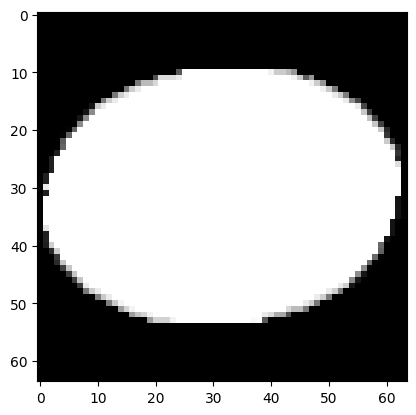

In [ ]:
phi = integrate_flow(v_param, n_steps, (H, W))
warped = warp_image_torch(I0.unsqueeze(0).unsqueeze(0), phi)
plt.imshow(warped.detach().cpu(), cmap='gray')
plt.show()
